In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
!pip install pytorch-lightning

   ---------------------------------------- 0.0/802.2 kB ? eta -:--:--
    --------------------------------------- 10.2/802.2 kB ? eta -:--:--
   - ------------------------------------- 30.7/802.2 kB 435.7 kB/s eta 0:00:02
   --- ----------------------------------- 81.9/802.2 kB 762.6 kB/s eta 0:00:01
   --------- ------------------------------ 184.3/802.2 kB 1.2 MB/s eta 0:00:01
   -------------------- ------------------- 419.8/802.2 kB 2.0 MB/s eta 0:00:01
   ----------------------------- ---------- 583.7/802.2 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 802.2/802.2 kB 2.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
df = pd.read_csv('news_summary.csv' , encoding = 'latin-1' , engine='python')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [4]:
df.shape

(4514, 6)

In [5]:
df = df[["text" , "ctext"]]
df.columns = ["Summary" , "Text"]
df.head()

,Summary,Text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
l= []
for i in df["Text"].values:
  try:
    l.append(len(i))
  except:
    l.append(0)

C:\Users\shash\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shash\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


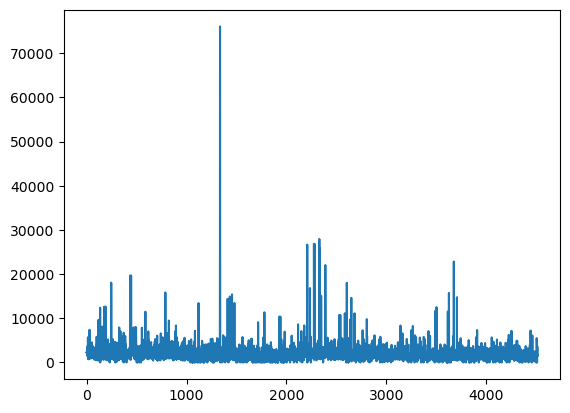

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(l)), y=l)
plt.show()

# Dropping the missing values

In [8]:
df.dropna(inplace=True)
df.shape

(4396, 2)

In [9]:
print("The Summary text for the 1st data smaple " , df.iloc[0,0])
print("The Text text for the 1st data smaple " , df.iloc[0,1])

The Summary text for the 1st data smaple  The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.
The Text text for the 1st data smaple  The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival colle

In [10]:
print("The Summary text for the 1st data smaple " , len(df.iloc[0,0]))
print("The Text text for the 1st data smaple " , len(df.iloc[0,1]))

The Summary text for the 1st data smaple  358
The Text text for the 1st data smaple  2313


- As we cant see above , the orginal text is of length of 2313 and summary test is of lenght of 358

In [11]:
import torch
import pytorch_lightning as pl
import re
from torch.utils.data import Dataset, DataLoader

In [12]:
class NewsDataset(Dataset):
    def __init__(self, source_texts, target_texts, tokenizer, source_len, target_len):
        self.source_texts = source_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.source_len = source_len
        self.target_len = target_len

    def __len__(self):
        return len(self.target_texts) - 1

    def __getitem__(self, idx):
        whitespace_handler = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
        text = " ".join(str(self.source_texts[idx]).split())
        summary = " ".join(str(self.target_texts[idx]).split())

        source = self.tokenizer.batch_encode_plus([whitespace_handler(text)],
                                                max_length= self.source_len,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True,
                                                add_special_tokens=True,
                                                return_tensors='pt')

        target = self.tokenizer.batch_encode_plus([whitespace_handler(summary)],
                                                max_length = self.target_len,
                                                padding='max_length',
                                                truncation=True,
                                                return_attention_mask=True,
                                                add_special_tokens=True,
                                                return_tensors='pt')

        labels = target['input_ids']
        labels[labels == 0] = -100

        return (source['input_ids'].squeeze(),
                source['attention_mask'].squeeze(),
                labels.squeeze(),
                target['attention_mask'].squeeze())

- Text1 - hi how are you
- Text 2 - hello i am doing good , what about you
- 1st senternce will be given a array of 4 and 2nd one will be given an array of 8 ,
if we add padding that is adding 0 at the end of each sentence array to make numerical represenatation of all text of equal lenght.

- Attnetion mask ( 0 , 1 )
Attnetion mask of the text1 - (1 , 1 , 1 , 1 , 0)
Attention Mask of the text2 - (1 , 1 , 1, 1, 1)

This indicates that which words should be given more imp and which values are padded values.

In [13]:
class NewsDataLoader(pl.LightningDataModule):
    def __init__(self, file_path, tokenizer, batch_size, val_split_size,
                 columns_name, source_len=1024, target_len=128, corpus_size=1000):
        super().__init__()
        self.tokenizer = tokenizer
        self.file_path = file_path
        self.batch_size = batch_size
        self.split_size = val_split_size
        self.nrows = corpus_size
        self.columns_name = columns_name
        self.target_len = target_len
        self.source_len = source_len

    def prepare_data(self):
        data = pd.read_csv(self.file_path, nrows=self.nrows, encoding='latin-1')
        data = data[self.columns_name]
        data = data.dropna()
        self.target_text = data.iloc[:,0].values
        self.source_text = data.iloc[:,-1].values

    def setup(self, stage=None):
        X_train, y_train, X_val, y_val = train_test_split(
            self.source_text, self.target_text, test_size=self.split_size
        )

        self.train_dataset = (X_train, y_train)
        self.val_dataset = (X_val, y_val)

    def train_dataloader(self):
        train_data = NewsDataset(source_texts=self.train_dataset[0],
                             target_texts=self.train_dataset[1],
                             tokenizer=self.tokenizer,
                             source_len=self.source_len,
                             target_len=self.target_len
                            )
        return DataLoader(train_data, self.batch_size, num_workers=6, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        val_data = NewsDataset(source_texts=self.val_dataset[0],
                          target_texts=self.val_dataset[1],
                          tokenizer=self.tokenizer,
                          source_len=self.source_len,
                          target_len=self.target_len
                          )
        return DataLoader(val_data, self.batch_size, num_workers=6, pin_memory=True)

In [14]:
class Finetuner(pl.LightningModule):
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.train_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, input_ids, attention_mask,
                decoder_attention_mask=None, labels=None):

        outputs= self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels
        )
        return outputs.loss

    def _step(self, batch):

        source_input_ids, source_attention_mask, target_input_ids, target_attention_mask = batch

        loss = self(input_ids=source_input_ids,
                      attention_mask=source_attention_mask,
                      decoder_attention_mask=target_attention_mask,
                      labels=target_input_ids
                      )
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.train_step_outputs.append({"loss": loss})
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.validation_step_outputs.append({"val_loss": loss})
        return {"val_loss": loss}

    def on_train_epoch_end(self):
        batch_loss = torch.stack([x["loss"] for x in self.train_step_outputs]).mean()
        self.log('train_loss', batch_loss, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        batch_loss = torch.stack([x["val_loss"] for x in self.validation_step_outputs]).mean()
        self.log('val_loss', batch_loss, prog_bar=True, logger=True)

    def configure_optimizers(self):
        model = self.model
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'}

In [15]:
from transformers import AutoTokenizer , AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("t5-small")

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

C:\Users\shash\anaconda3\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shash\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
dataloader = NewsDataLoader(tokenizer=tokenizer,
                            file_path='news_summary.csv',
                            val_split_size=0.3, batch_size=4, columns_name=['text', 'ctext'])

dataloader.prepare_data()

dataloader.setup()

In [17]:
model = Finetuner(model, tokenizer)

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
logger = TensorBoardLogger("lightning_logs", name='summary')

In [19]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=False, mode="min")

In [20]:
trainer = pl.Trainer(check_val_every_n_epoch=1, max_epochs=5,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     logger=logger
                     )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
torch.cuda.empty_cache()
trainer.fit(model, dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: lightning_logs\summary
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\shash\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


In [ ]:
metric = trainer.callback_metrics
loss = metric['val_loss']
float(loss)

In [ ]:
def summarizeText(text):
  whitespace_handler = lambda k: re.sub('\s+' , ' ' , re.sub(r'\n' , ' ' , k.strip()))
  text_encoding = tokenizer(whitespace_handler(text) ,
                             max_length = 400,
                             padding = 'max_length',
                             truncation = True,
                             return_tensors = 'pt')
  generated_ids = model.model.generate(
      input_ids=text_encoding['input_ids'],
      attention_mask=text_encoding['attention_mask'],
      max_length=100,
      num_beams=4,
      no_repeat_ngram_size=2,
      early_stopping=True,
      length_penalty=2.0)

  preds = [
      tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for g in generated_ids
  ]
  return "".join(preds)

In [ ]:
text = """The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the Daman and Diu administration a day apart. The circular was withdrawn through a one-line order issued late in the evening by the UT?s department of personnel and administrative reforms.?The circular is ridiculous. There are sensitivities involved. How can the government dictate who I should tie rakhi to? We should maintain the professionalism of a workplace? an official told Hindustan Times earlier in the day. She refused to be identified.The notice was issued on Daman and Diu administrator and former Gujarat home minister Praful Kodabhai Patel?s direction, sources said.Rakshabandhan, a celebration of the bond between brothers and sisters, is one of several Hindu festivities and rituals that are no longer confined of private, family affairs but have become tools to push politic al ideologies.In 2014, the year BJP stormed to power at the Centre, Rashtriya Swayamsevak Sangh (RSS) chief Mohan Bhagwat said the festival had ?national significance? and should be celebrated widely ?to protect Hindu culture and live by the values enshrined in it?. The RSS is the ideological parent of the ruling BJP.Last year, women ministers in the Modi government went to the border areas to celebrate the festival with soldiers. A year before, all cabinet ministers were asked to go to their constituencies for the festival."""
print(len(text))
print(len(summarizeText(text)))
summarizeText(text)

In [ ]:
paper = """In this study, we introduce CT-LLM, a 2B large language model (LLM)
that illustrates a pivotal shift towards prioritizing the Chinese language in
developing LLMs. Uniquely initiated from scratch, CT-LLM diverges from
the conventional methodology by primarily incorporating Chinese textual
data, utilizing an extensive corpus of 1,200 billion tokens, including 800 billion Chinese tokens, 300 billion English tokens, and 100 billion code tokens.
This strategic composition facilitates the model’s exceptional proficiency
in understanding and processing Chinese, a capability further enhanced
through alignment techniques. Demonstrating remarkable performance on
the CHC-Bench, CT-LLM excels in Chinese language tasks, and showcases
its adeptness in English through SFT. This research challenges the prevailing paradigm of training LLMs predominantly on English corpora and then
adapting them to other languages, broadening the horizons for LLM training methodologies. By open-sourcing the full process of training a Chinese
LLM, including a detailed data processing procedure with the obtained
Massive Appropriate Pretraining Chinese Corpus (MAP-CC), a well-chosen
multidisciplinary Chinese Hard Case Benchmark (CHC-Bench), and the
2B-size Chinese Tiny LLM (CT-LLM), we aim to foster further exploration
and innovation in both academia and industry, paving the way for more
inclusive and versatile language models.
1 Introduction
In the burgeoning field of linguistic intelligence, large language models (LLMs) emerge as a
cornerstone of natural language processing (NLP), demonstrating remarkable capabilities
in understanding and generating human language. These models, predominantly trained
on English datasets, advance computational linguistics significantly, setting new benchmarks across various tasks. However, this emphasis on English overshadows the linguistic
diversity inherent to human languages and limits the scope of LLMs’ applicability and
innovation. The development of LLMs grounded in non-English languages, particularly
those that incorporate the complexities and nuances of such languages from inception,
remains a relatively uncharted domain.
This study introduces the Chinese Tiny LLM (CT-LLM), a pioneering endeavor to redefine
the landscape of LLMs by shifting towards prioritizing the Chinese language. CT-LLM,
with its 2 billion parameters, diverges from traditional approaches by being meticulously
pre-trained on a comprehensive corpus comprising 1,200 billion tokens. This corpus, distinct
* Equal Technical Contributions.
† Corresponding Authors.
1
arXiv:2404.04167v3 [cs.CL] 9 Apr 2024
Chinese Tiny LLM
in its composition, includes an extensive collection of 800 billion Chinese tokens, 300 billion
English tokens, and 100 billion code tokens. Our careful data processing procedures offer
the Massive Appropriate Pretraining Chinese Corpus (MAP-CC), enhancing the quality of
Chinese web corpora and setting a new standard for dataset preparation in the field. The
strategic inclusion of a diverse and substantial amount of Chinese textual data enables CTLLM to achieve exceptional proficiency in processing and understanding Chinese, setting a
new precedent for LLM capabilities.
Our approach further refines the model’s competencies through supervised fine-tuning(SFT).
The SFT not only bolsters the model’s adeptness in Chinese language tasks but also enhances
its versatility in comprehending and generating English text, showcasing its multi-lingual
prowess. We also utilize preference optimization techniques to align CT-LLM with human
preferences, to enhance its harmlessness and helpfulness. Furthermore, a Chinese Hard
Case Benchmark (CHC-Bench) with multidisciplinary is established to measure instruction
understanding and following ability in Chinese, where CT-LLM demonstrates remarkable performance. By challenging the prevailing norms of training LLMs primarily on
English corpora, CT-LLM expands the horizons of language model training, offering fresh
perspectives on the potentialities of non-English-centric LLMs.
Central to our research is the open-sourcing of the entire training process for CT-LLM,
including the meticulous data processing procedures undertaken to curate the Massive
Appropriate Pretraining Chinese Corpus (MAP-CC) and the establishment of the multidisciplinary Chinese Hard Case Benchmark (CHC-Bench). Through the dissemination of our
methodologies and findings, we aim to foster a more inclusive and diverse landscape for
future LLM developments, encouraging the exploration of models that better reflect the
vast array of human languages and cultures. Our contributions are threefold:
MAP-CC An open-source Chinese pretraining dataset with a scale of 800 billion tokens,
along with a detailed suite of procedures for cleaning Chinese web corpora, offering the
NLP community high-quality Chinese pretraining data and an effective methodology for
data preparation.
CHC-Bench A well-chosen multidisciplinary Chinese hard cases instruction understanding
and following benchmark.
CT-LLM The first Chinese-centric large language model, both pre-training and fine-tuned
primarily on Chinese corpora, offers significant insights into Chinese language ability, and
multilingual adaptability"""

In [ ]:
print(len(paper))
print(len(summarizeText(paper)))
summarizeText(paper)